# Epidemic Modeling with Epydemix (R Version)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ngozzi/tech-transfer-epdemix/blob/main/sessions/session-3/r-colab/01_modeling_tutorial.ipynb)

This tutorial walks through building an age-structured SEIR model, running simulations with real population data, and comparing intervention scenarios—all using R via the `reticulate` package.

**What you'll learn:**
- Define compartmental models and transitions from scratch
- Load population data and contact matrices for 400+ geographies
- Run stochastic simulations and visualize results
- Model non-pharmaceutical interventions and compare scenarios

In [1]:
# Colab installation (skip if running locally)
!pip install epydemix
%load_ext rpy2.ipython

ERROR: Exception:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 106, in _run_wrapper
    status = _inner_run()
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/base_command.py", line 97, in _inner_run
    return self.run(options, args)
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/commands/install.py", line 484, in run
    installed_versions[distribution.canonical_name] = distribution.version
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_internal/metadata/pkg_resources.py", line 192, in version
    return parse_version(self._dist.version)
  File "/opt/anaconda3/lib/python3.8/site-packages/pip/_vendor/packaging/version.py", line 56, in parse
    return Version(version)
  File "/opt/anaconda3/lib/python3.8/site-packages

In [2]:
%%R
# Install and load reticulate
if (!require("reticulate", quietly = TRUE)) {
  install.packages("reticulate")
}
library(reticulate)
use_python("/usr/bin/python3", required = TRUE)
py_config()


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    python:         /opt/anaconda3/bin/python
libpython:      /opt/anaconda3/bin/python3.8
pythonhome:     /opt/anaconda3:/opt/anaconda3
version:        3.8.8 (default, Apr 13 2021, 12:59:45)  [Clang 10.0.0 ]
numpy:          /opt/anaconda3/lib/python3.8/site-packages/numpy
numpy_version:  1.24.4

NOTE: Python version was forced by the current process


In addition: Warning message:
package ‘reticulate’ was built under R version 4.3.3 


---
## 1. Building an SEIR Model from Scratch

Compartmental models divide the population into states. The **SEIR model** has four:

- **S** (Susceptible): Can be infected
- **E** (Exposed): Infected but not yet infectious (latent period)
- **I** (Infectious): Can transmit the disease
- **R** (Recovered): Immune

Transitions between compartments are either:
- **Mediated**: Depends on interactions (S→E requires contact with I)
- **Spontaneous**: Happens at a fixed rate (E→I, I→R)

In [3]:
%%R
# Import epydemix
epydemix <- import("epydemix")
EpiModel <- epydemix$EpiModel

# Helper for creating Python tuples
builtins <- import_builtins()

# Create the model with four compartments
model <- EpiModel(
  name = "SEIR Model",
  compartments = c("S", "E", "I", "R")
)

# Add transitions
# S → E: mediated by contact with infectious individuals (rate β)
params_SE <- builtins$tuple(list("beta", "I"))
model$add_transition(source = "S", target = "E", params = params_SE, kind = "mediated")

# E → I: spontaneous at rate σ (1/latent period)
model$add_transition(source = "E", target = "I", params = "sigma", kind = "spontaneous")

# I → R: spontaneous at rate γ (1/infectious period)
model$add_transition(source = "I", target = "R", params = "gamma", kind = "spontaneous")

# Set parameter values
model$add_parameter("beta", 0.035)   # transmission rate
model$add_parameter("sigma", 0.2)    # 1/5 days latent period
model$add_parameter("gamma", 0.1)    # 1/10 days infectious period

model

EpiModel(name='SEIR Model')
Compartments: 4
  S, E, I, R
Transitions: 3
  Transitions between compartments:
    S -> E, params: ['beta', 'I'] (kind: mediated)
    E -> I, params: sigma (kind: spontaneous)
    I -> R, params: gamma (kind: spontaneous)
Parameters: 3
  Model parameters:
    beta: 0.035
    sigma: 0.2
    gamma: 0.1
Population: epydemix_population
  Population size: 100000 individuals
  Demographic groups: 1
    0



---
## 2. Loading Population Data

Epydemix includes demographic data and synthetic contact matrices for 400+ regions worldwide. Let's load data for **United States**.

The `Population` object contains:
- **Population distribution** by age group
- **Contact matrices** for different settings (home, school, work, community)

You can see all supported locations [here](https://github.com/epistorm/epydemix-data/blob/main/locations.csv).

In [4]:
%%R
# Load population module
load_epydemix_population <- epydemix$population$load_epydemix_population

# Load US population data
population <- load_epydemix_population("United_States")
population

Population(name='United_States')
Demographic groups: 5 groups
Population distribution:
  - 0-4: 18608139 individuals
  - 5-19: 63540783 individuals
  - 20-49: 132780169 individuals
  - 50-64: 63172279 individuals
  - 65+: 60019216 individuals
Contact matrices: 4 layers
Available layers:
  - school
  - work
  - home
  - community



In [5]:
%%R
# Attach the population to our model
model$set_population(population)

### Exploring the Population

Let's visualize the age distribution and contact patterns.

<Axes: title={'center': 'Population Distribution (%)'}, xlabel='Age group', ylabel='Population (%)'>


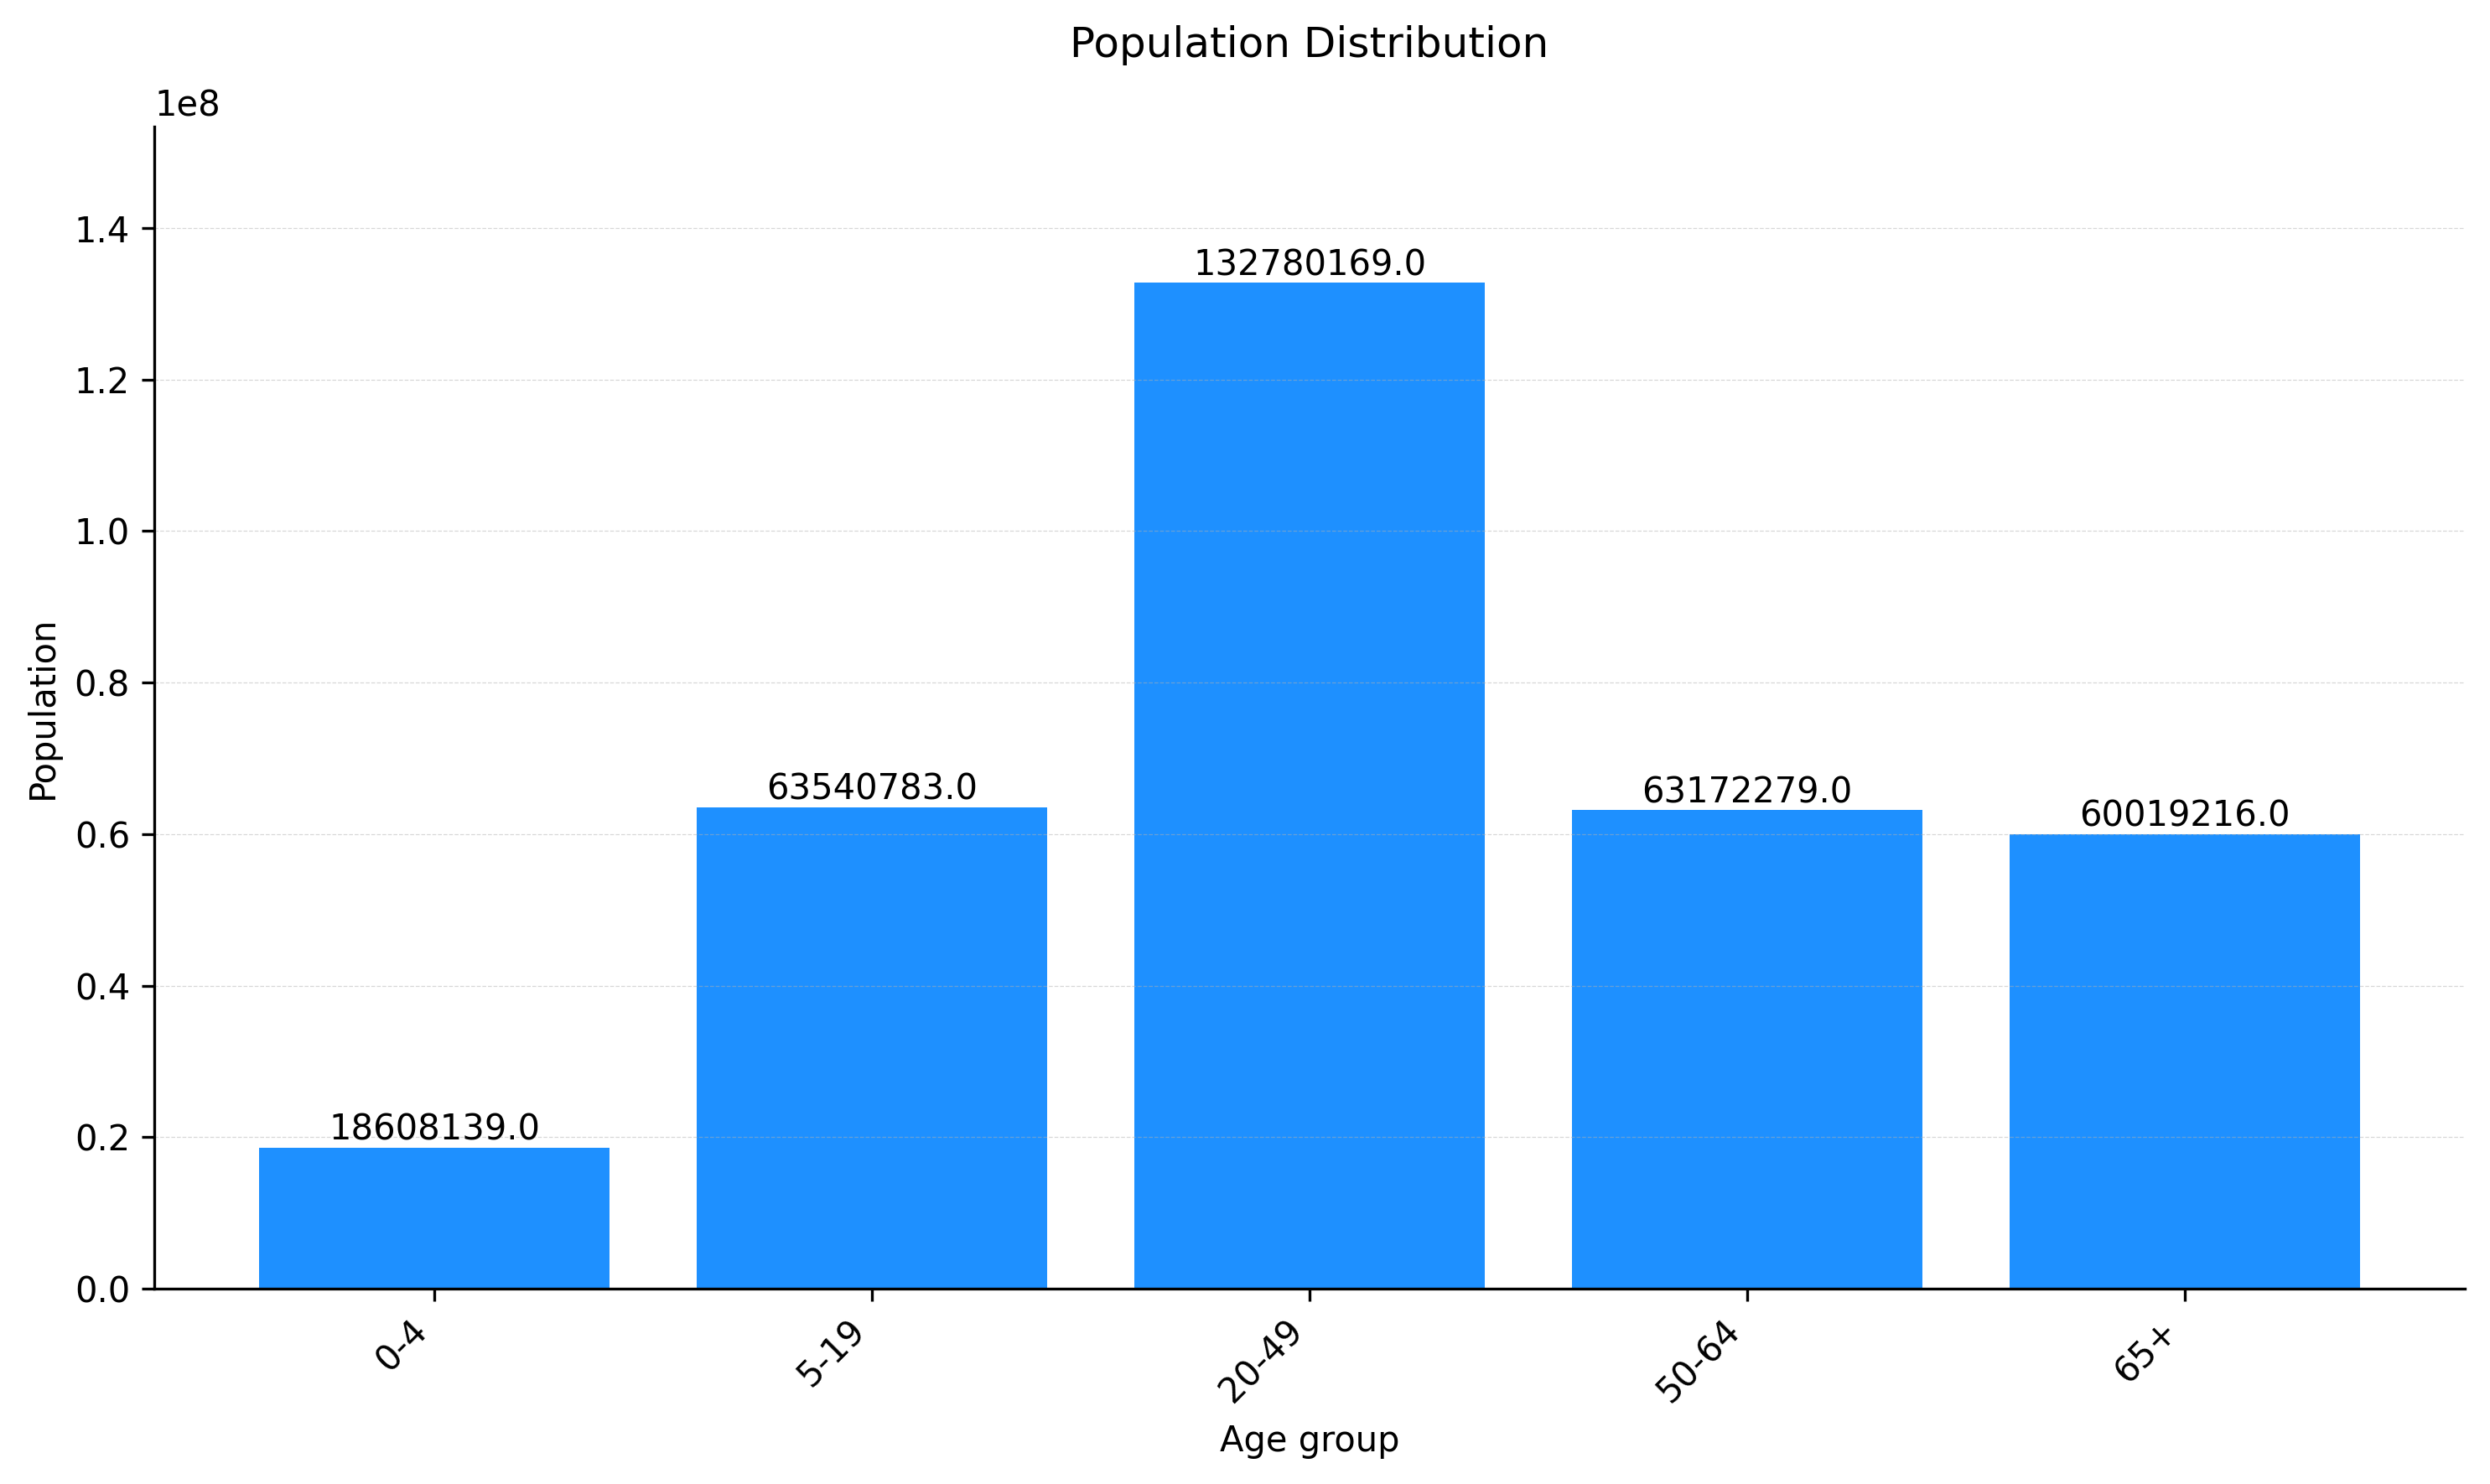

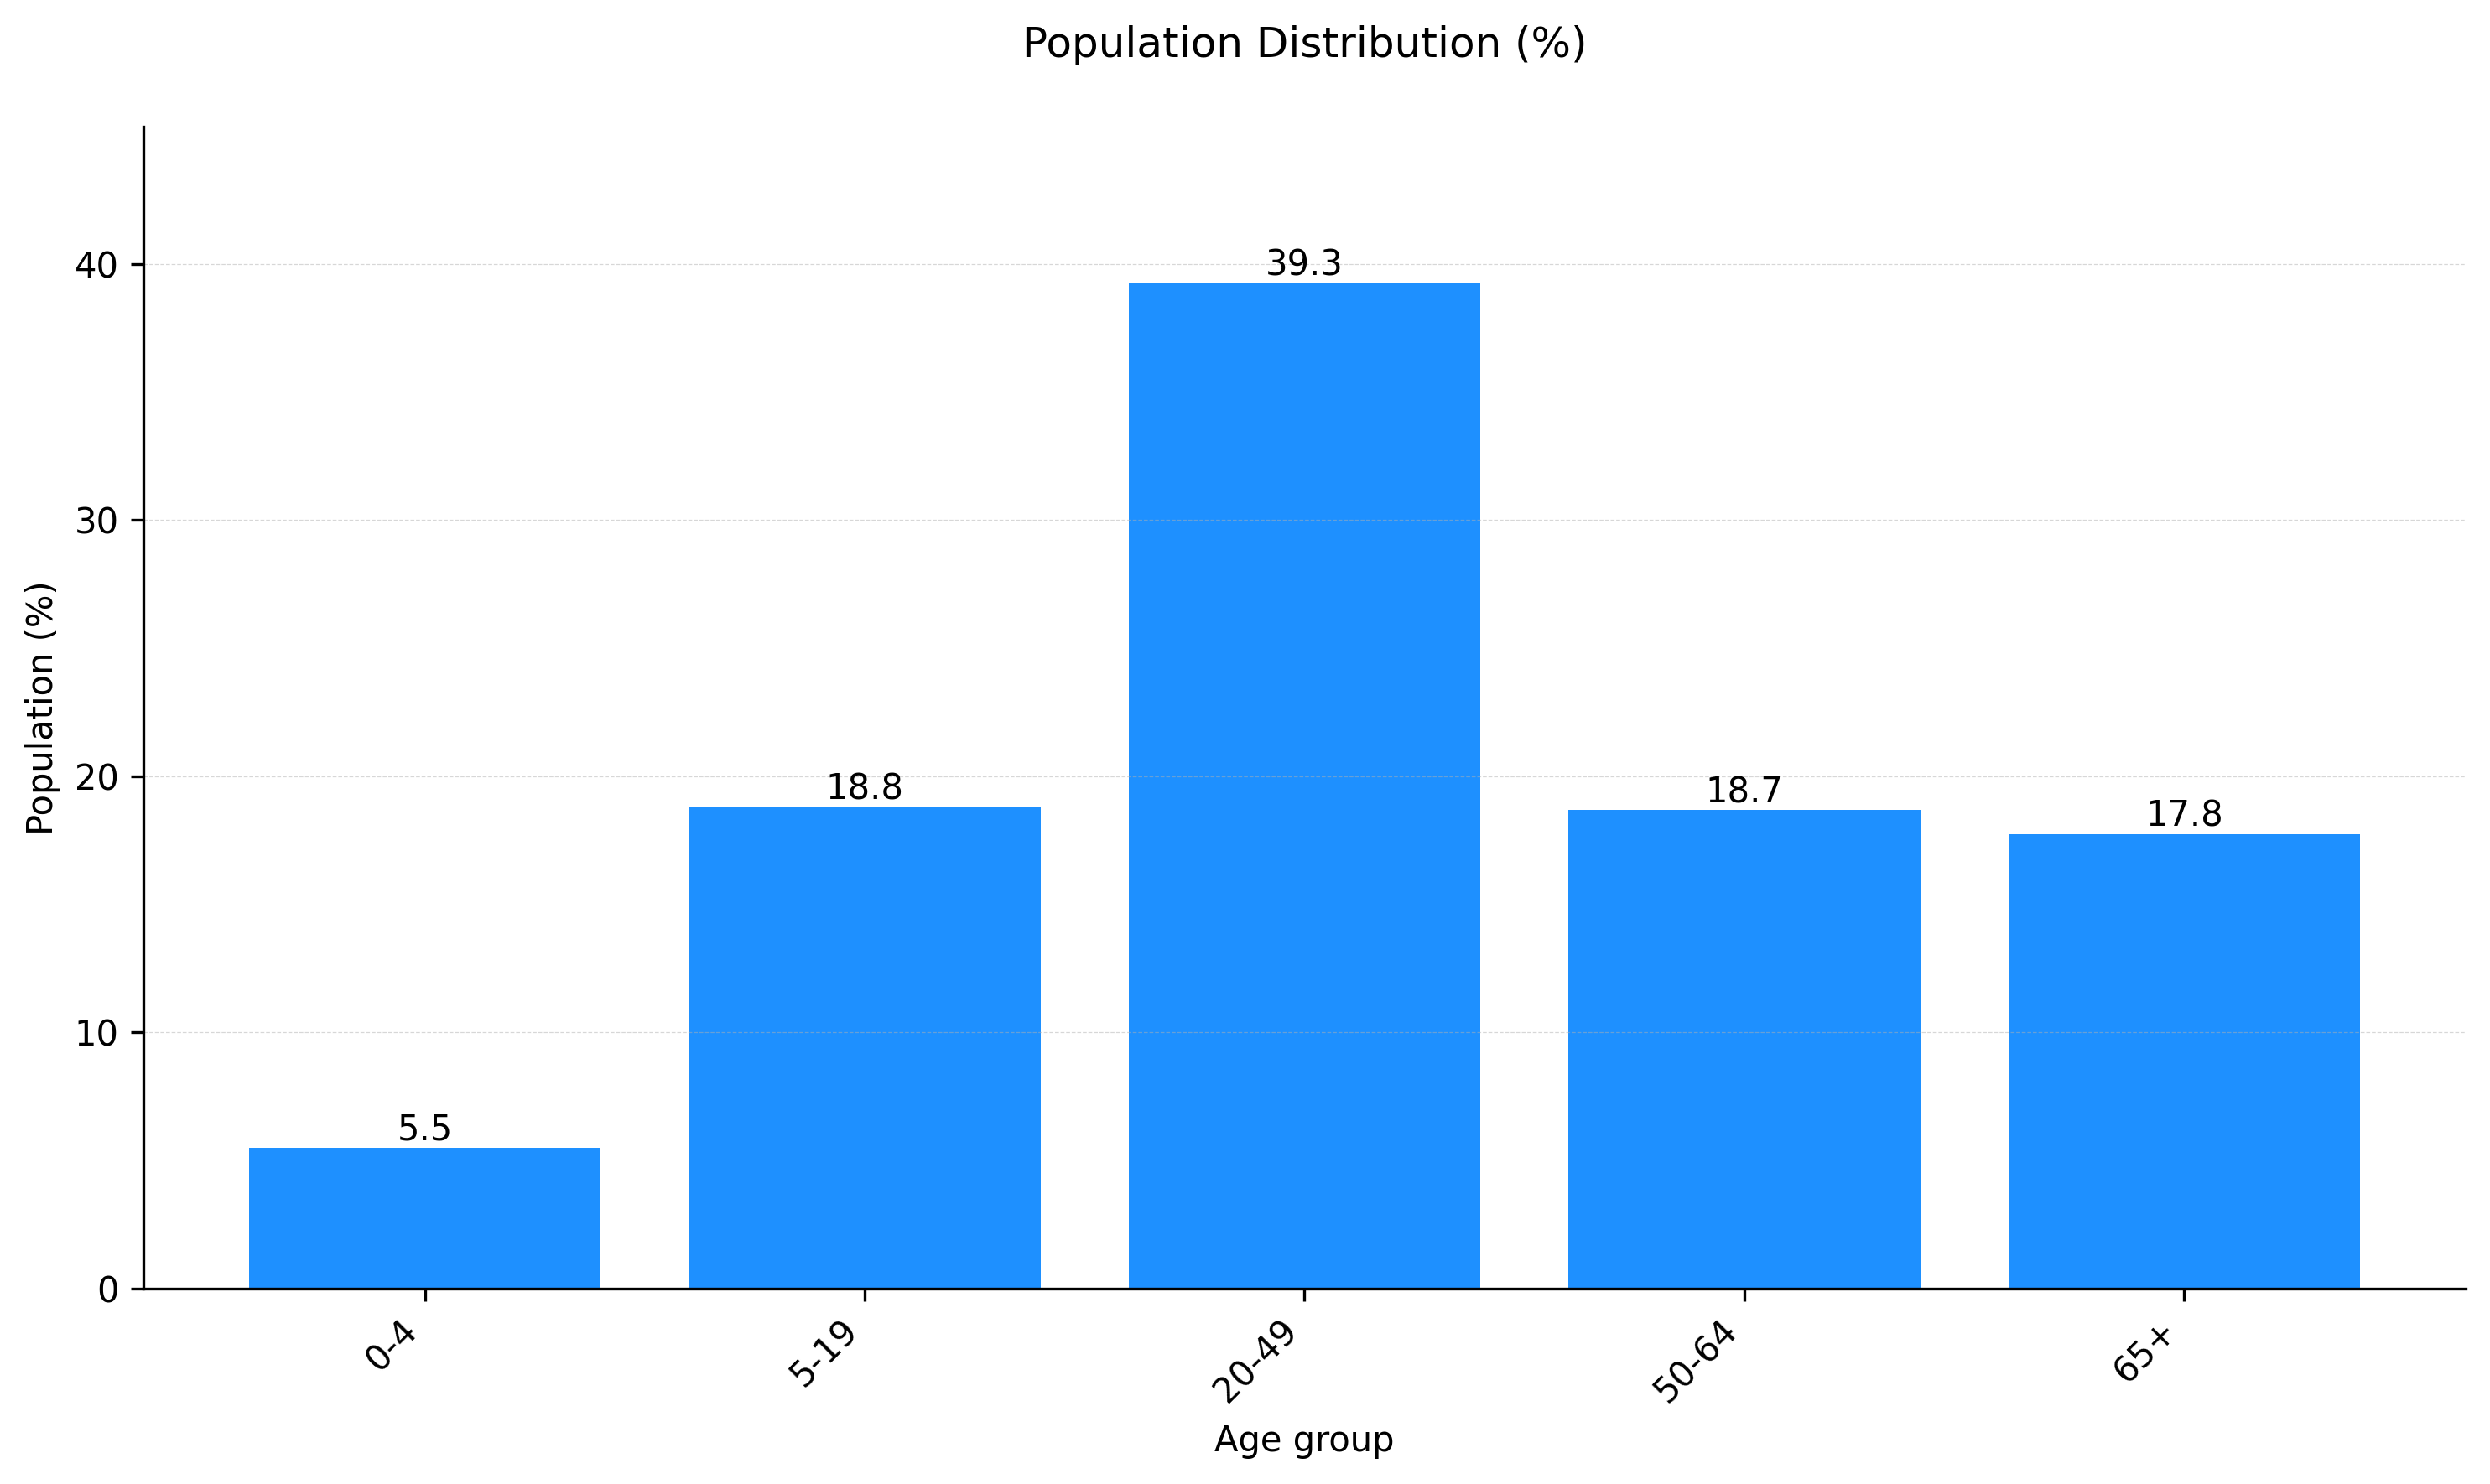

In [6]:
%%R
# Import visualization functions
viz <- import("epydemix.visualization")
plot_contact_matrix <- viz$plot_contact_matrix
plot_population <- viz$plot_population

# Plot population distribution
plot_population(population, title = "Population Distribution")
plot_population(population, title = "Population Distribution (%)", show_perc = TRUE)

<Axes: title={'center': 'Contact Matrix - community'}, xlabel='Age group (contacted)', ylabel='Age group (contacting)'>


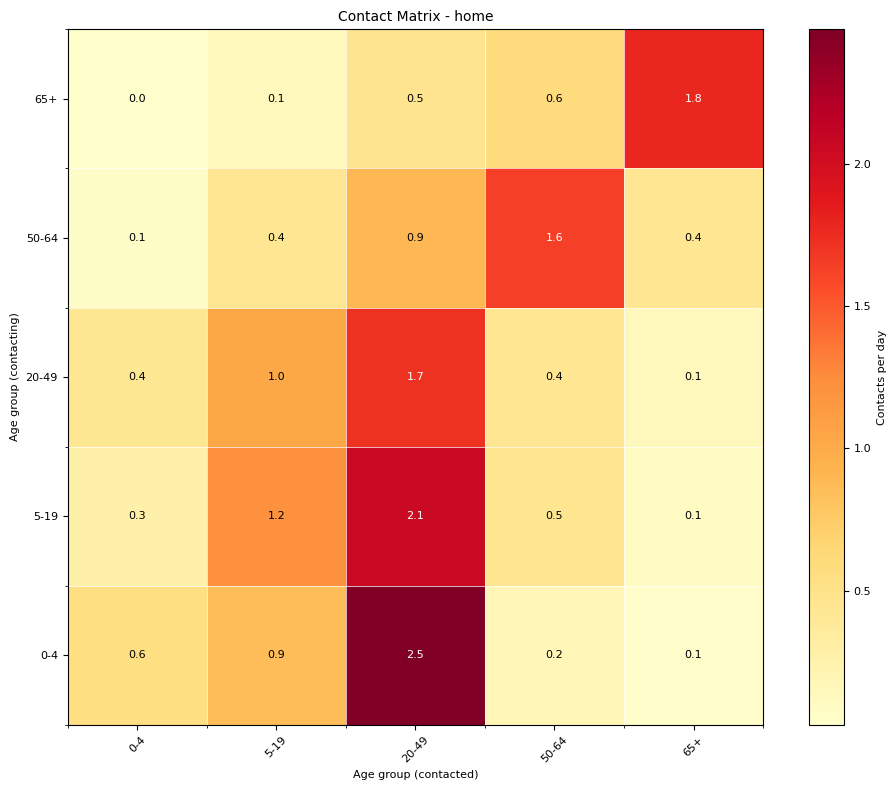

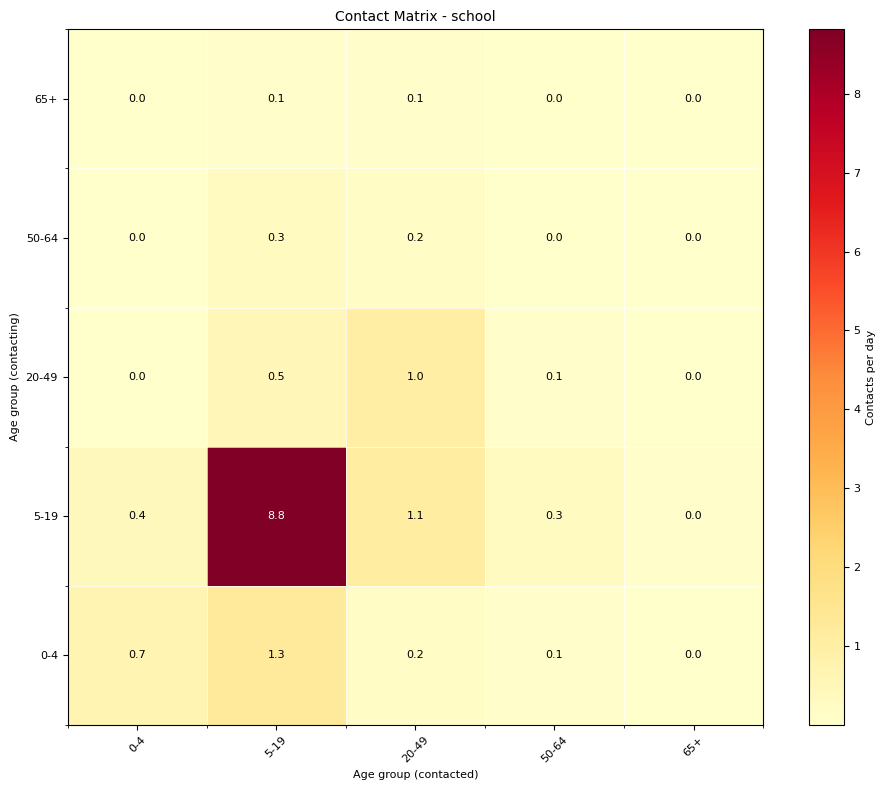

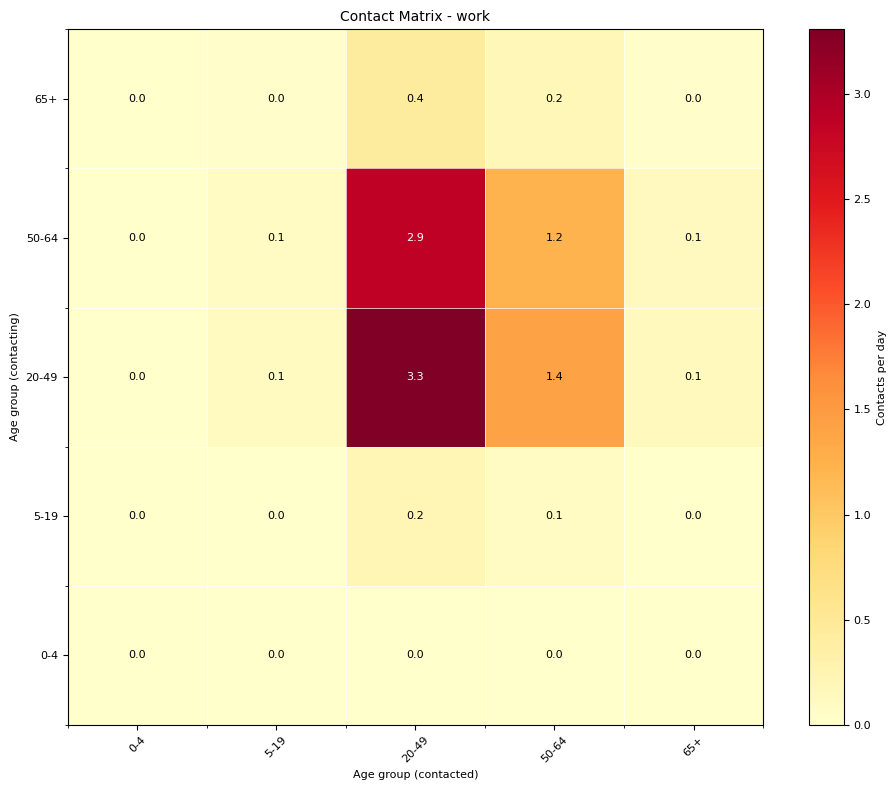

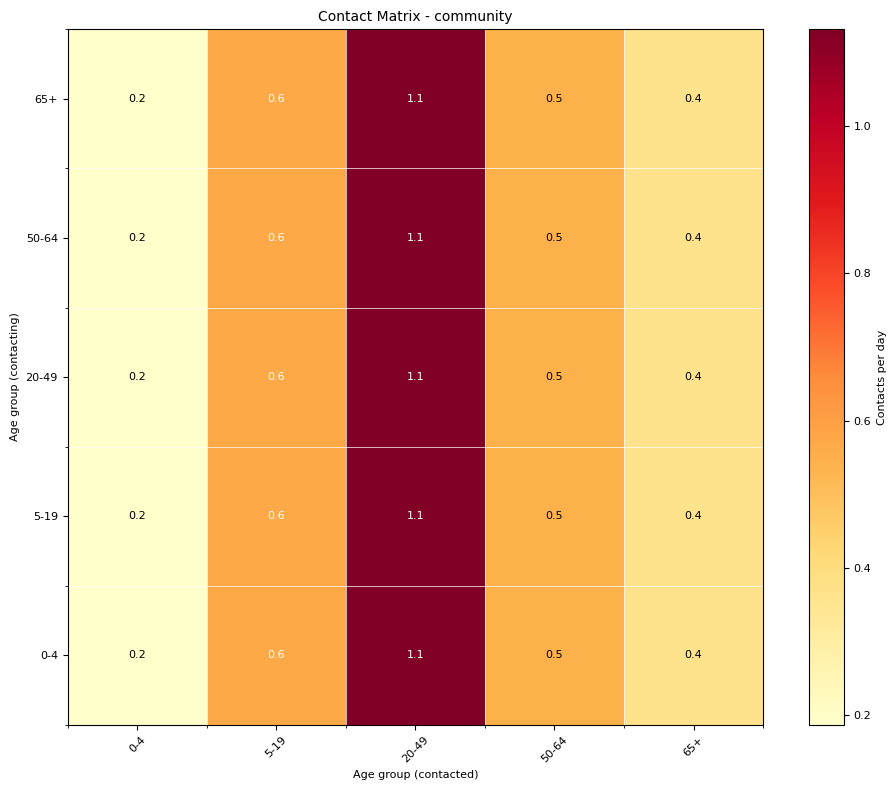

In [7]:
%%R
# Contact matrices by setting
plot_contact_matrix(population, "home", show_values = TRUE)
plot_contact_matrix(population, "school", show_values = TRUE)
plot_contact_matrix(population, "work", show_values = TRUE)
plot_contact_matrix(population, "community", show_values = TRUE)

**Reading contact matrices:** Each cell $(i, j)$ shows the average daily contacts that a person in age group $i$ has with people in age group $j$. Notice how:
- **School** contacts are concentrated among children (5-19)
- **Work** contacts peak in working-age adults (20-64)
- **Home** contacts show intergenerational mixing
- **Community** contacts are more diffuse

### What is the Model $R_0$?

The reproduction number $R_0$ is the average number of people an infected person will infect. For the SEIR model on an age-structured population, it can be computed as:    

$$
R_0 = \frac{\beta}{\gamma} \rho(C)
$$

Where $\rho(C)$ is the spectral radius (i.e., the largest eigenvalue) of the contact matrix $C$.

In [8]:
%%R
# Get overall contact matrix as sum of individual matrices
contact_matrices <- model$population$contact_matrices
C <- contact_matrices$school + contact_matrices$home + contact_matrices$work + contact_matrices$community

# Compute spectral radius (largest eigenvalue)
eigenvalues <- eigen(C)$values
rho <- max(Re(eigenvalues))

# Compute R0
beta <- as.numeric(model$parameters["beta"])
gamma <- as.numeric(model$parameters["gamma"])
R0 <- beta / gamma * rho

cat(sprintf("R0: %.2f\n", R0))

R0: 4.91


---
## 3. Running Simulations

Epydemix uses **stochastic chain-binomial** simulations. Each run produces a different trajectory due to randomness—we run many simulations to capture uncertainty.

In [9]:
%%R
# Compute percentage for seeding ~10 infected individuals
Nk_r <- py_to_r(population$Nk)
percentage_in_agents <- 10 / sum(Nk_r)

# Run 25 stochastic simulations
results <- model$run_simulations(
  start_date = "2026-01-01",
  end_date = "2026-08-31",
  Nsim = 25L,
  percentage_in_agents = percentage_in_agents
)

### Visualizing Results

The `SimulationResults` object provides methods to extract compartment counts and transitions over time.

<Axes: title={'center': 'SEIR Epidemic Trajectory'}>


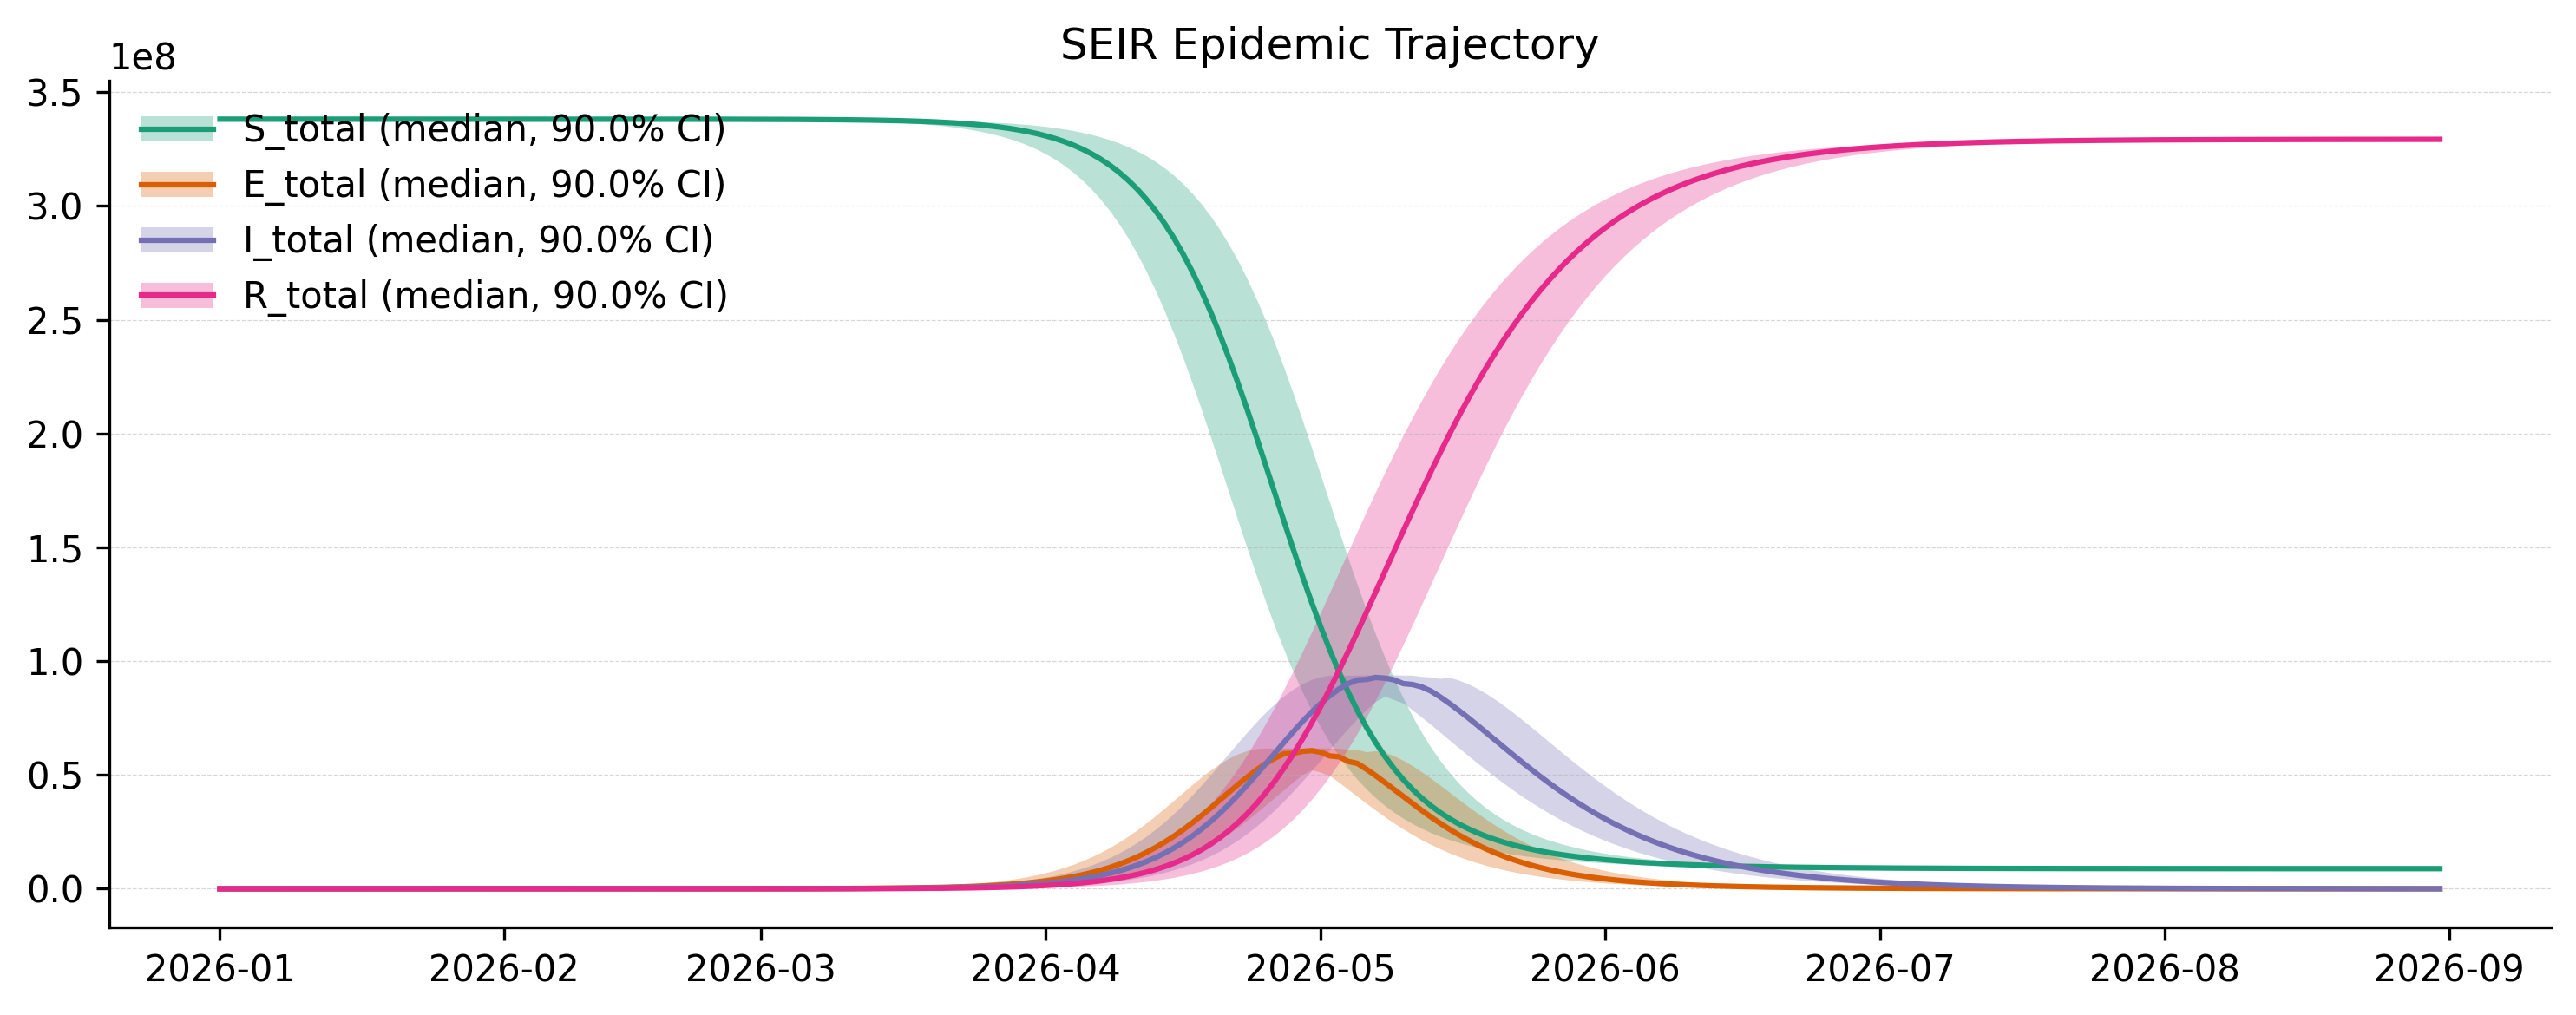

In [10]:
%%R
# Import plotting functions
plot_quantiles <- viz$plot_quantiles
plot_trajectories <- viz$plot_trajectories

# Get quantiles (median, 25th, 75th percentiles) across simulations
df_quantiles <- results$get_quantiles_compartments()

# Plot all compartments
plot_quantiles(
  df_quantiles,
  columns = c("S_total", "E_total", "I_total", "R_total"),
  title = "SEIR Epidemic Trajectory"
)

<Axes: title={'center': 'Infections by Age Group'}>


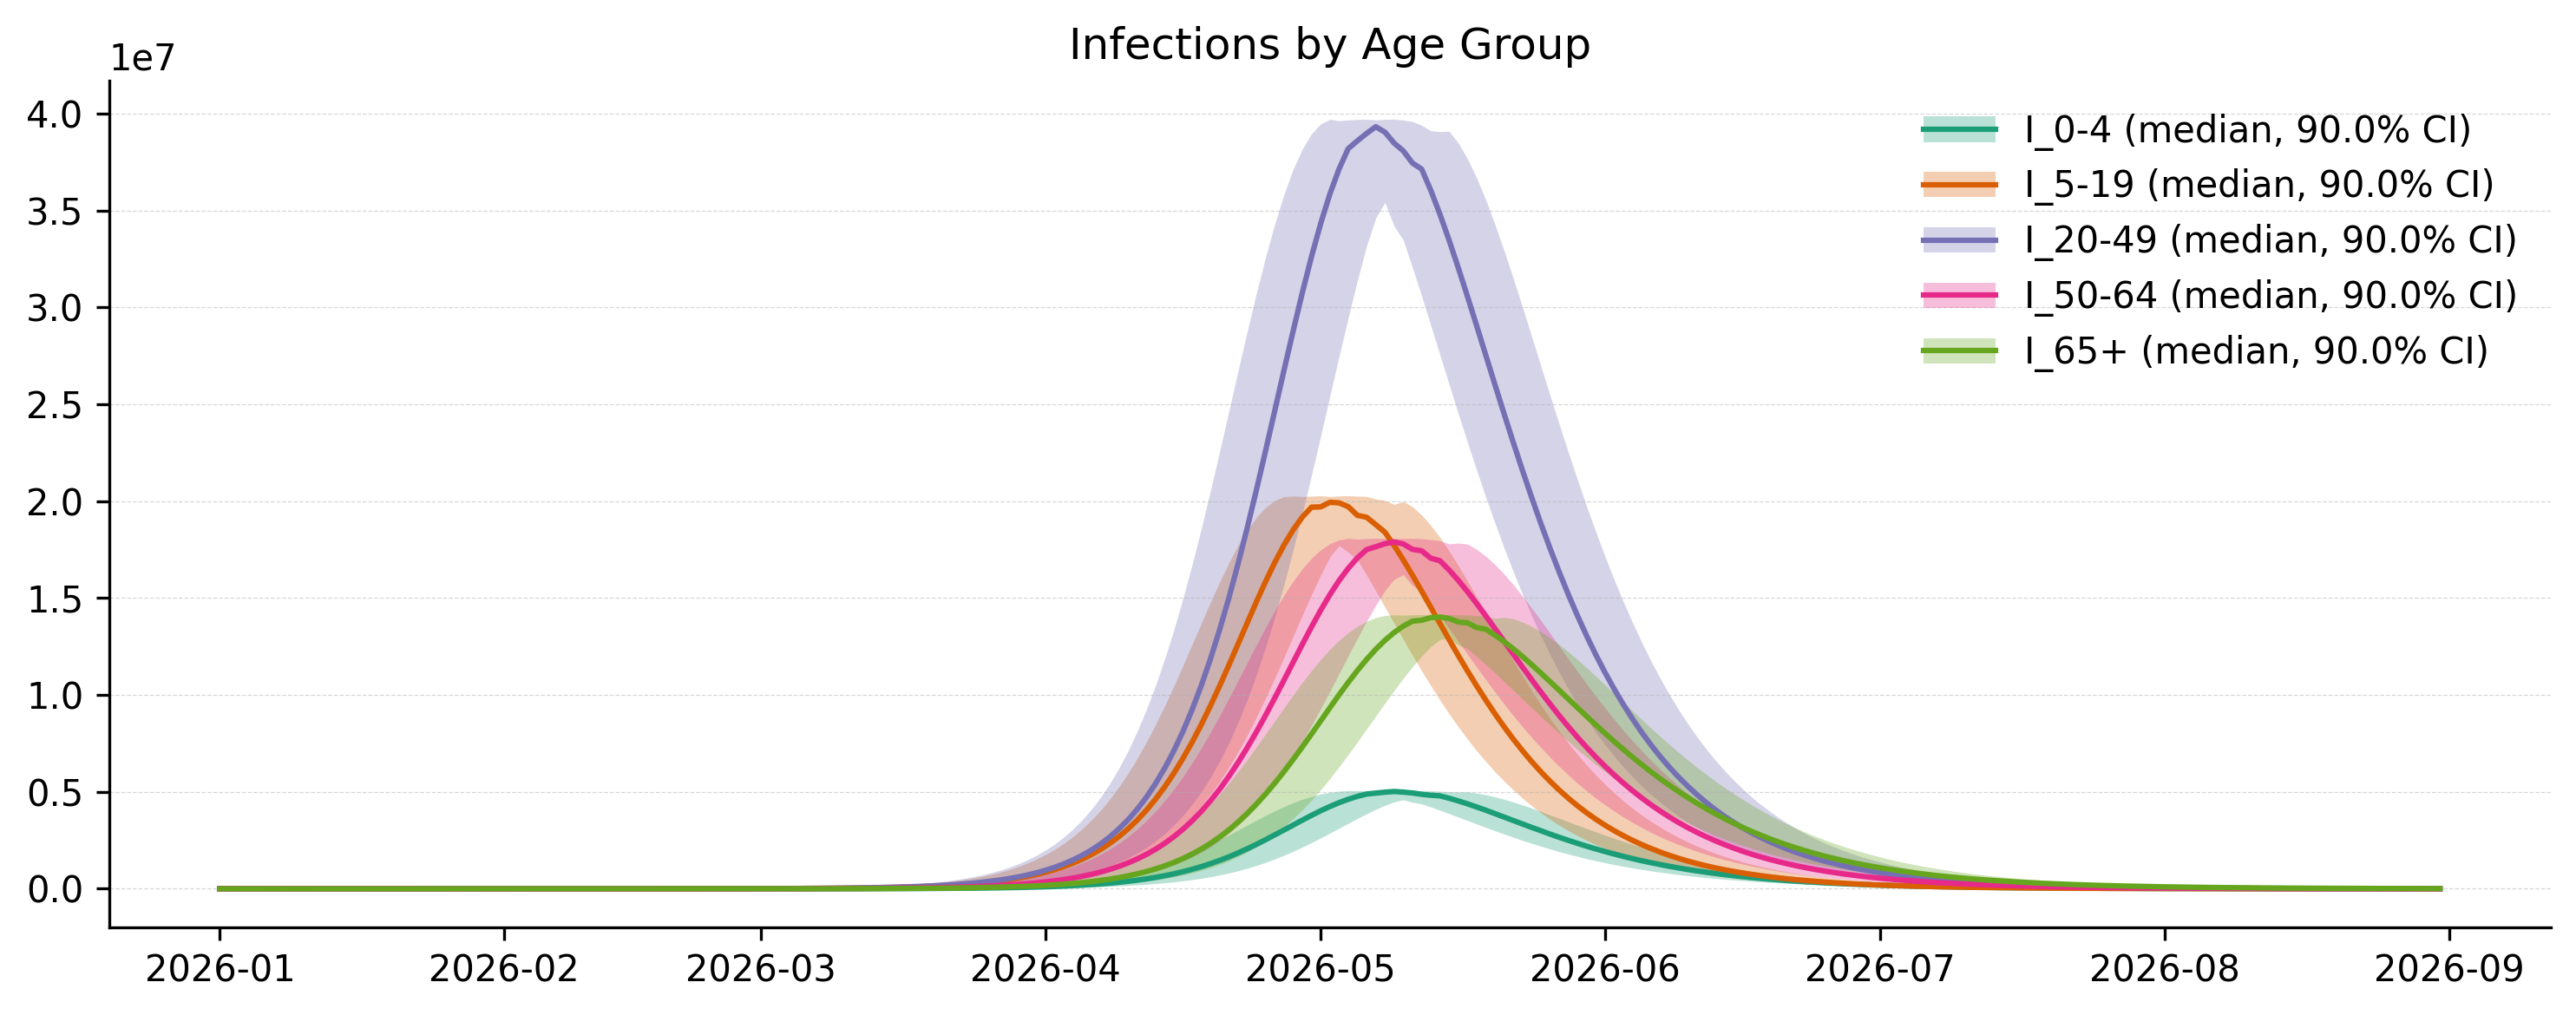

In [11]:
%%R
# Infections by age group
plot_quantiles(
  df_quantiles,
  columns = c("I_0-4", "I_5-19", "I_20-49", "I_50-64", "I_65+"),
  title = "Infections by Age Group",
  legend_loc = "upper right"
)

<Axes: title={'center': 'Individual Simulation Trajectories (Infected)'}>


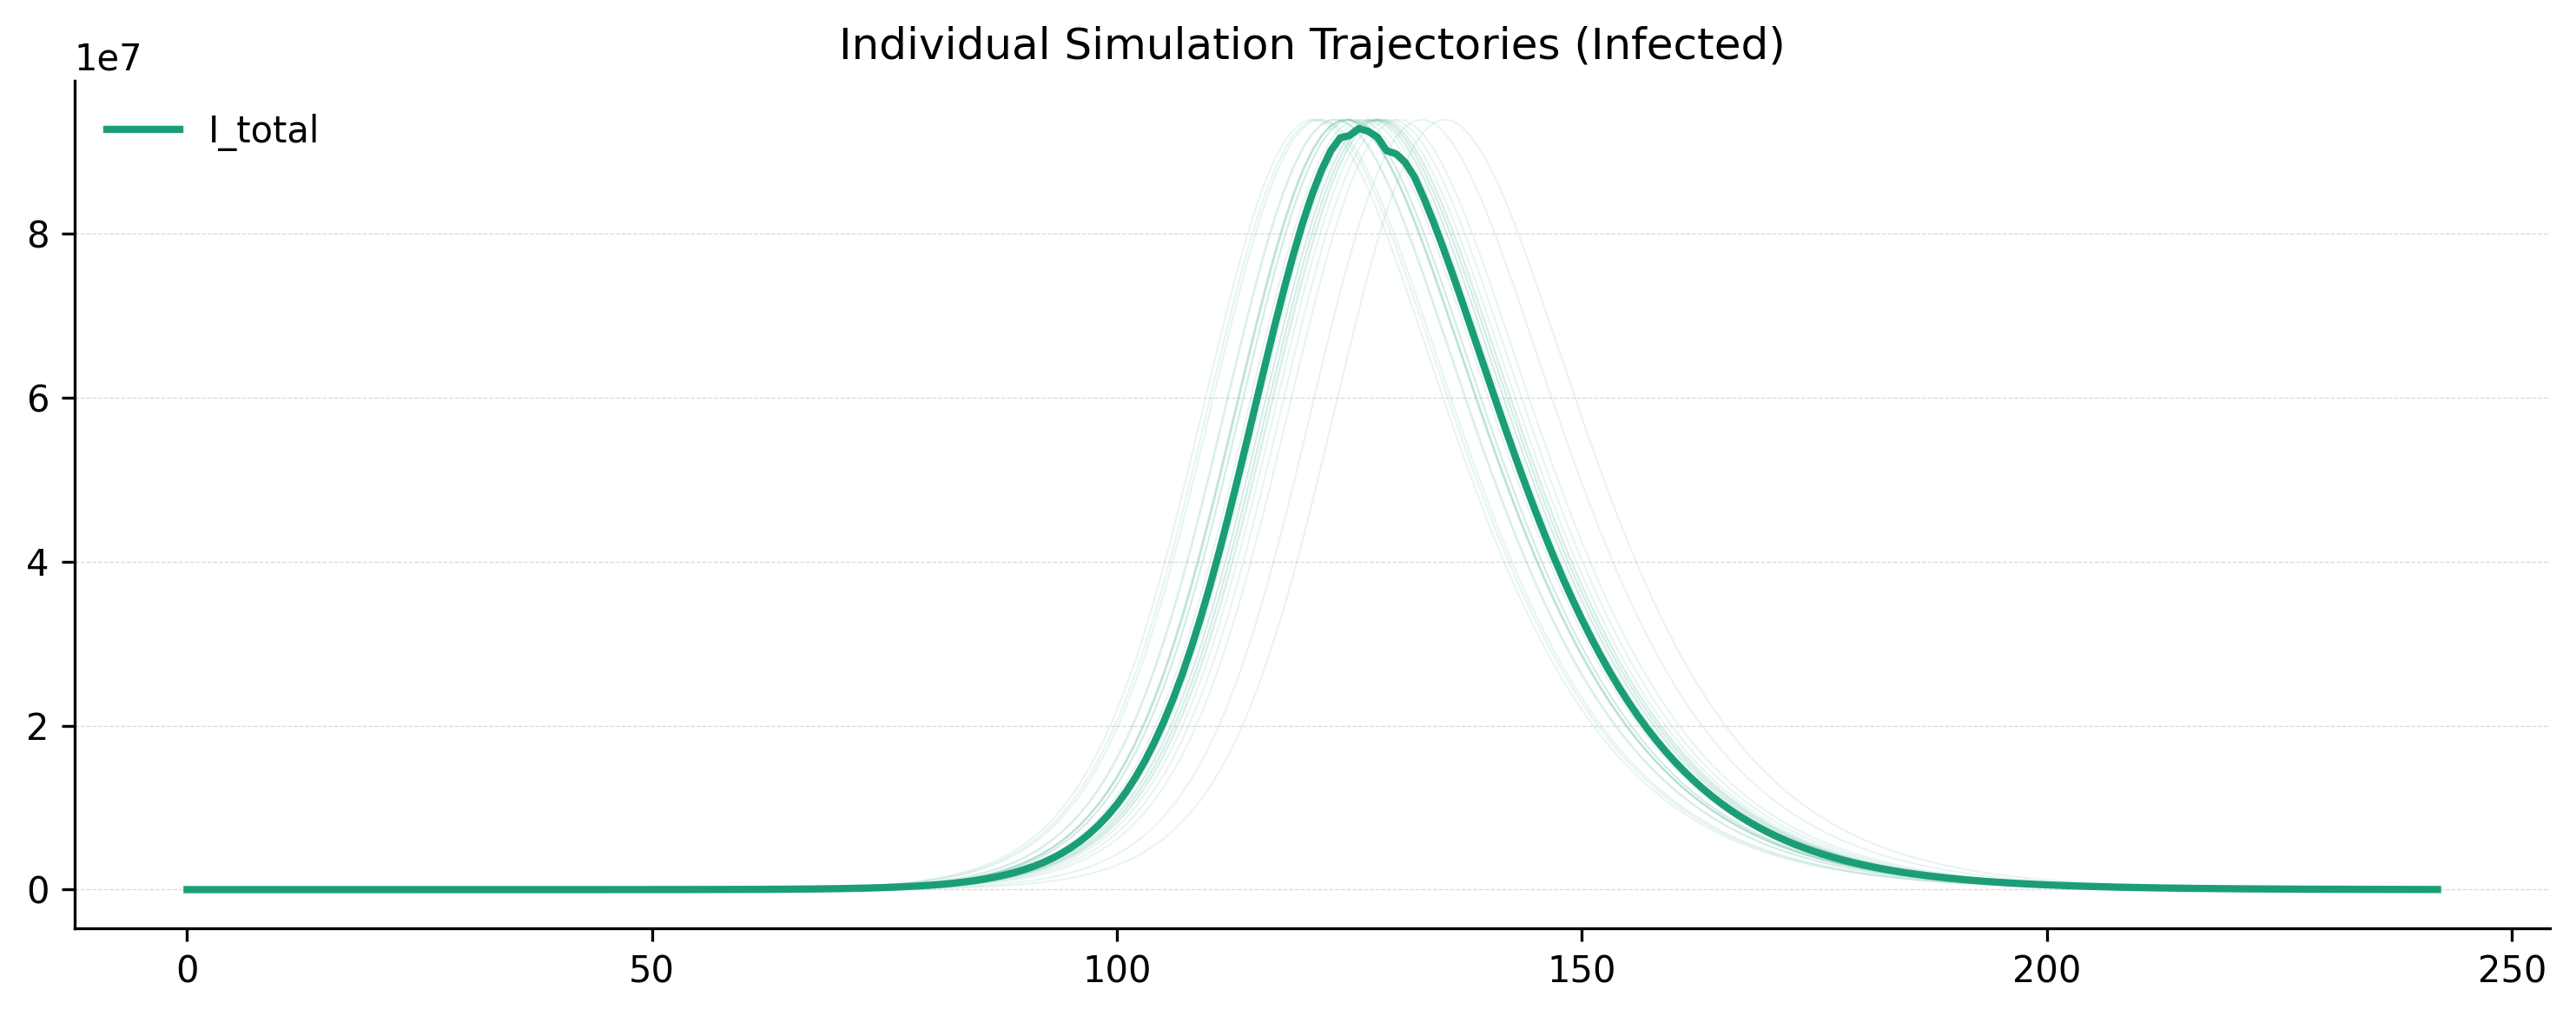

In [12]:
%%R
# Show individual simulation trajectories
trajectories <- results$get_stacked_compartments()

plot_trajectories(
  trajectories,
  columns = c("I_total"),
  title = "Individual Simulation Trajectories (Infected)"
)

---
## 4. Modeling Interventions

Non-pharmaceutical interventions (NPIs) reduce transmission by limiting contacts. Epydemix supports two approaches:

1. **`add_intervention`**: Reduce contacts in specific settings (school closure, work-from-home)
2. **`override_parameter`**: Modify transmission parameters directly (masking, social distancing)

Let's compare a baseline scenario to intervention scenarios.

In [13]:
%%R
# Function to create a fresh SEIR model
create_seir_model <- function() {
  m <- EpiModel(name = "SEIR", compartments = c("S", "E", "I", "R"))
  
  params_SE <- builtins$tuple(list("beta", "I"))
  m$add_transition(source = "S", target = "E", params = params_SE, kind = "mediated")
  m$add_transition(source = "E", target = "I", params = "sigma", kind = "spontaneous")
  m$add_transition(source = "I", target = "R", params = "gamma", kind = "spontaneous")
  
  m$add_parameter("beta", 0.035)
  m$add_parameter("sigma", 0.2)
  m$add_parameter("gamma", 0.1)
  
  m$set_population(population)
  return(m)
}

# Create three identical models for comparison
model_baseline <- create_seir_model()
model_contact_intervention <- create_seir_model()
model_transmission_intervention <- create_seir_model()

In [14]:
%%R
# Model 2: Contact interventions (school closure + work-from-home)

# School closure: 70% reduction in school contacts (Apr 1 - Aug 31)
model_contact_intervention$add_intervention(
  layer_name = "school",
  start_date = "2026-04-01",
  end_date = "2026-08-31",
  reduction_factor = 0.3,  # 70% reduction
  name = "school closure"
)

# Work-from-home: 50% reduction in work contacts (Apr 1 - Aug 31)
model_contact_intervention$add_intervention(
  layer_name = "work",
  start_date = "2026-04-01",
  end_date = "2026-08-31",
  reduction_factor = 0.5,  # 50% reduction
  name = "work from home"
)

# Model 3: Transmission reduction (e.g., masking, social distancing)
# Reduces beta by ~30% during the intervention period
model_transmission_intervention$override_parameter(
  start_date = "2026-04-01",
  end_date = "2026-08-31",
  parameter_name = "beta",
  value = 0.025  # reduced from 0.035
)

### Visualizing Intervention Impact on Contacts

The **spectral radius** of the contact matrix is proportional to $R_0$. We can visualize how interventions reduce it over time.

<Axes: title={'center': 'Contact Pattern Intensity - Overall Layer'}, xlabel='Date', ylabel='Change in spectral radius (%)'>


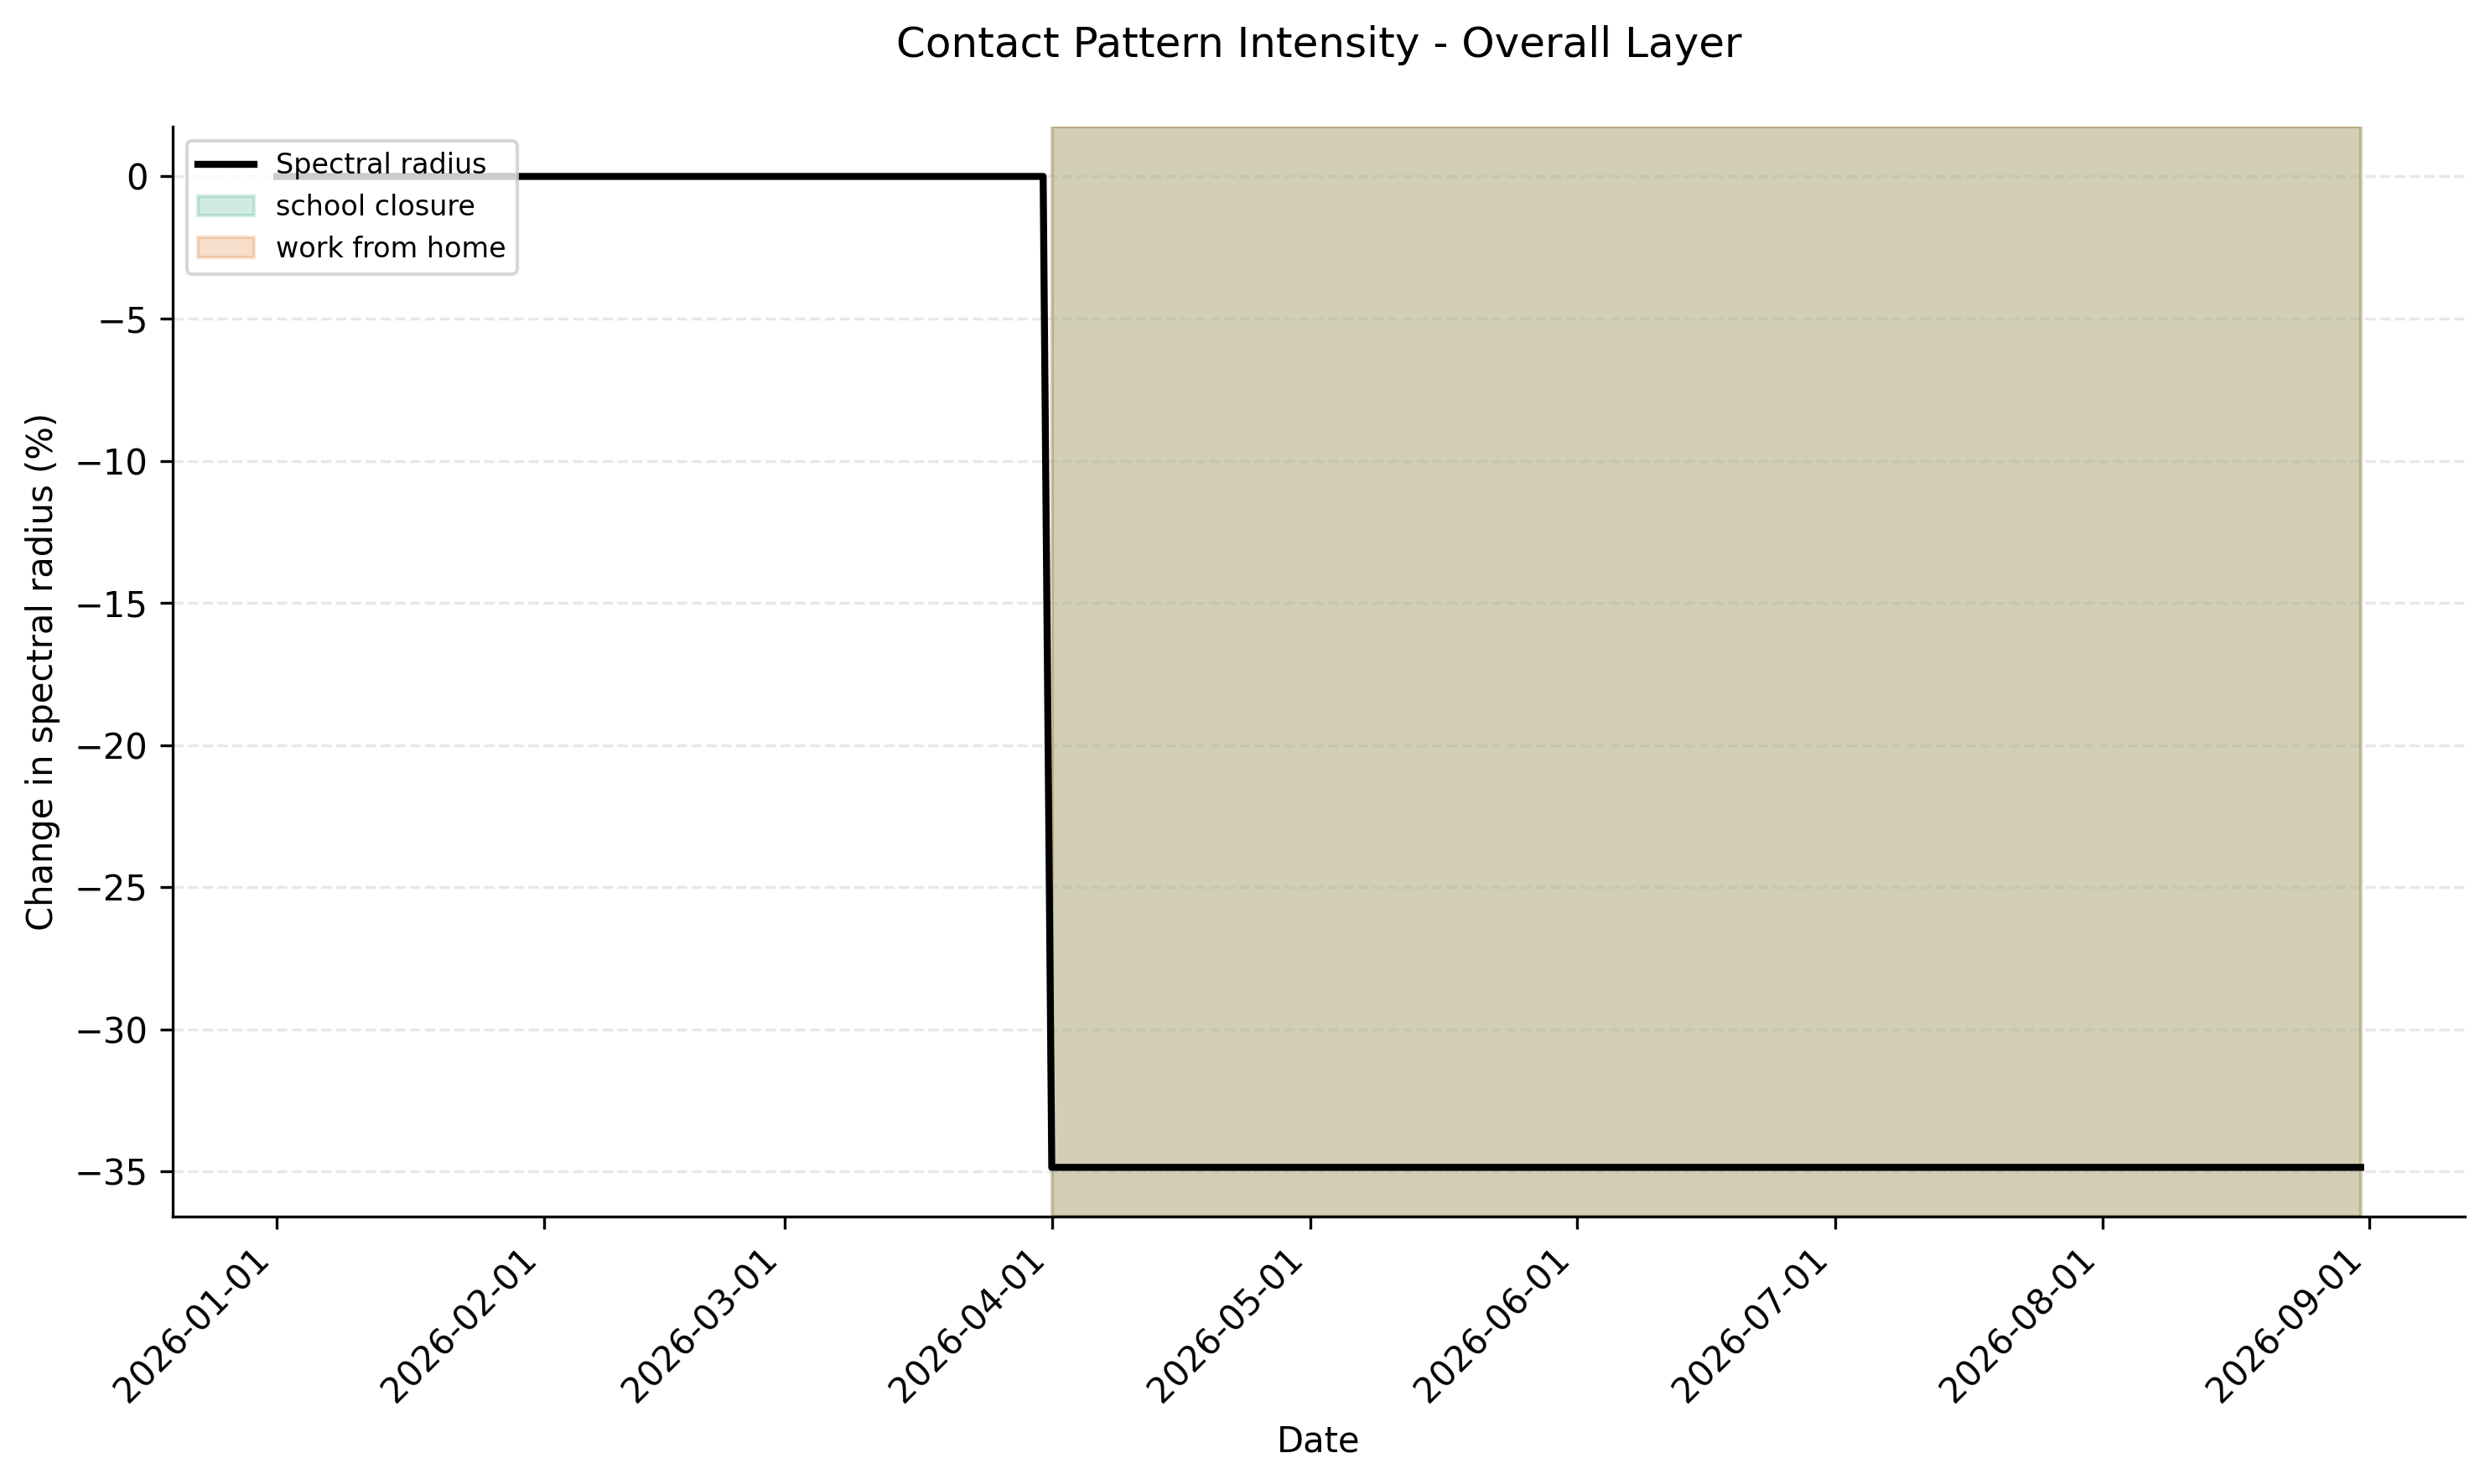

In [15]:
%%R
# Import utils
utils_module <- import("epydemix.utils")
compute_simulation_dates <- utils_module$compute_simulation_dates
plot_spectral_radius <- viz$plot_spectral_radius

# Compute contact reductions for visualization
simulation_dates <- compute_simulation_dates("2026-01-01", "2026-08-31")
model_contact_intervention$compute_contact_reductions(simulation_dates)

# Plot spectral radius change
plot_spectral_radius(
  model_contact_intervention,
  show_perc = TRUE
)

### Comparing Scenarios

In [16]:
%%R
# Simulation parameters
Nk_r <- py_to_r(population$Nk)
pct <- 10 / sum(Nk_r)

# Run all three scenarios
cat("Running baseline...\n")
results_baseline <- model_baseline$run_simulations(
  start_date = "2026-01-01",
  end_date = "2026-08-31",
  Nsim = 25L,
  percentage_in_agents = pct
)

cat("Running contact intervention...\n")
results_contact <- model_contact_intervention$run_simulations(
  start_date = "2026-01-01",
  end_date = "2026-08-31",
  Nsim = 25L,
  percentage_in_agents = pct
)

cat("Running transmission intervention...\n")
results_transmission <- model_transmission_intervention$run_simulations(
  start_date = "2026-01-01",
  end_date = "2026-08-31",
  Nsim = 25L,
  percentage_in_agents = pct
)

cat("Done!\n")

Running baseline...
Running contact intervention...
Running transmission intervention...
Done!


<Axes: title={'center': 'Comparison of Intervention Strategies'}>


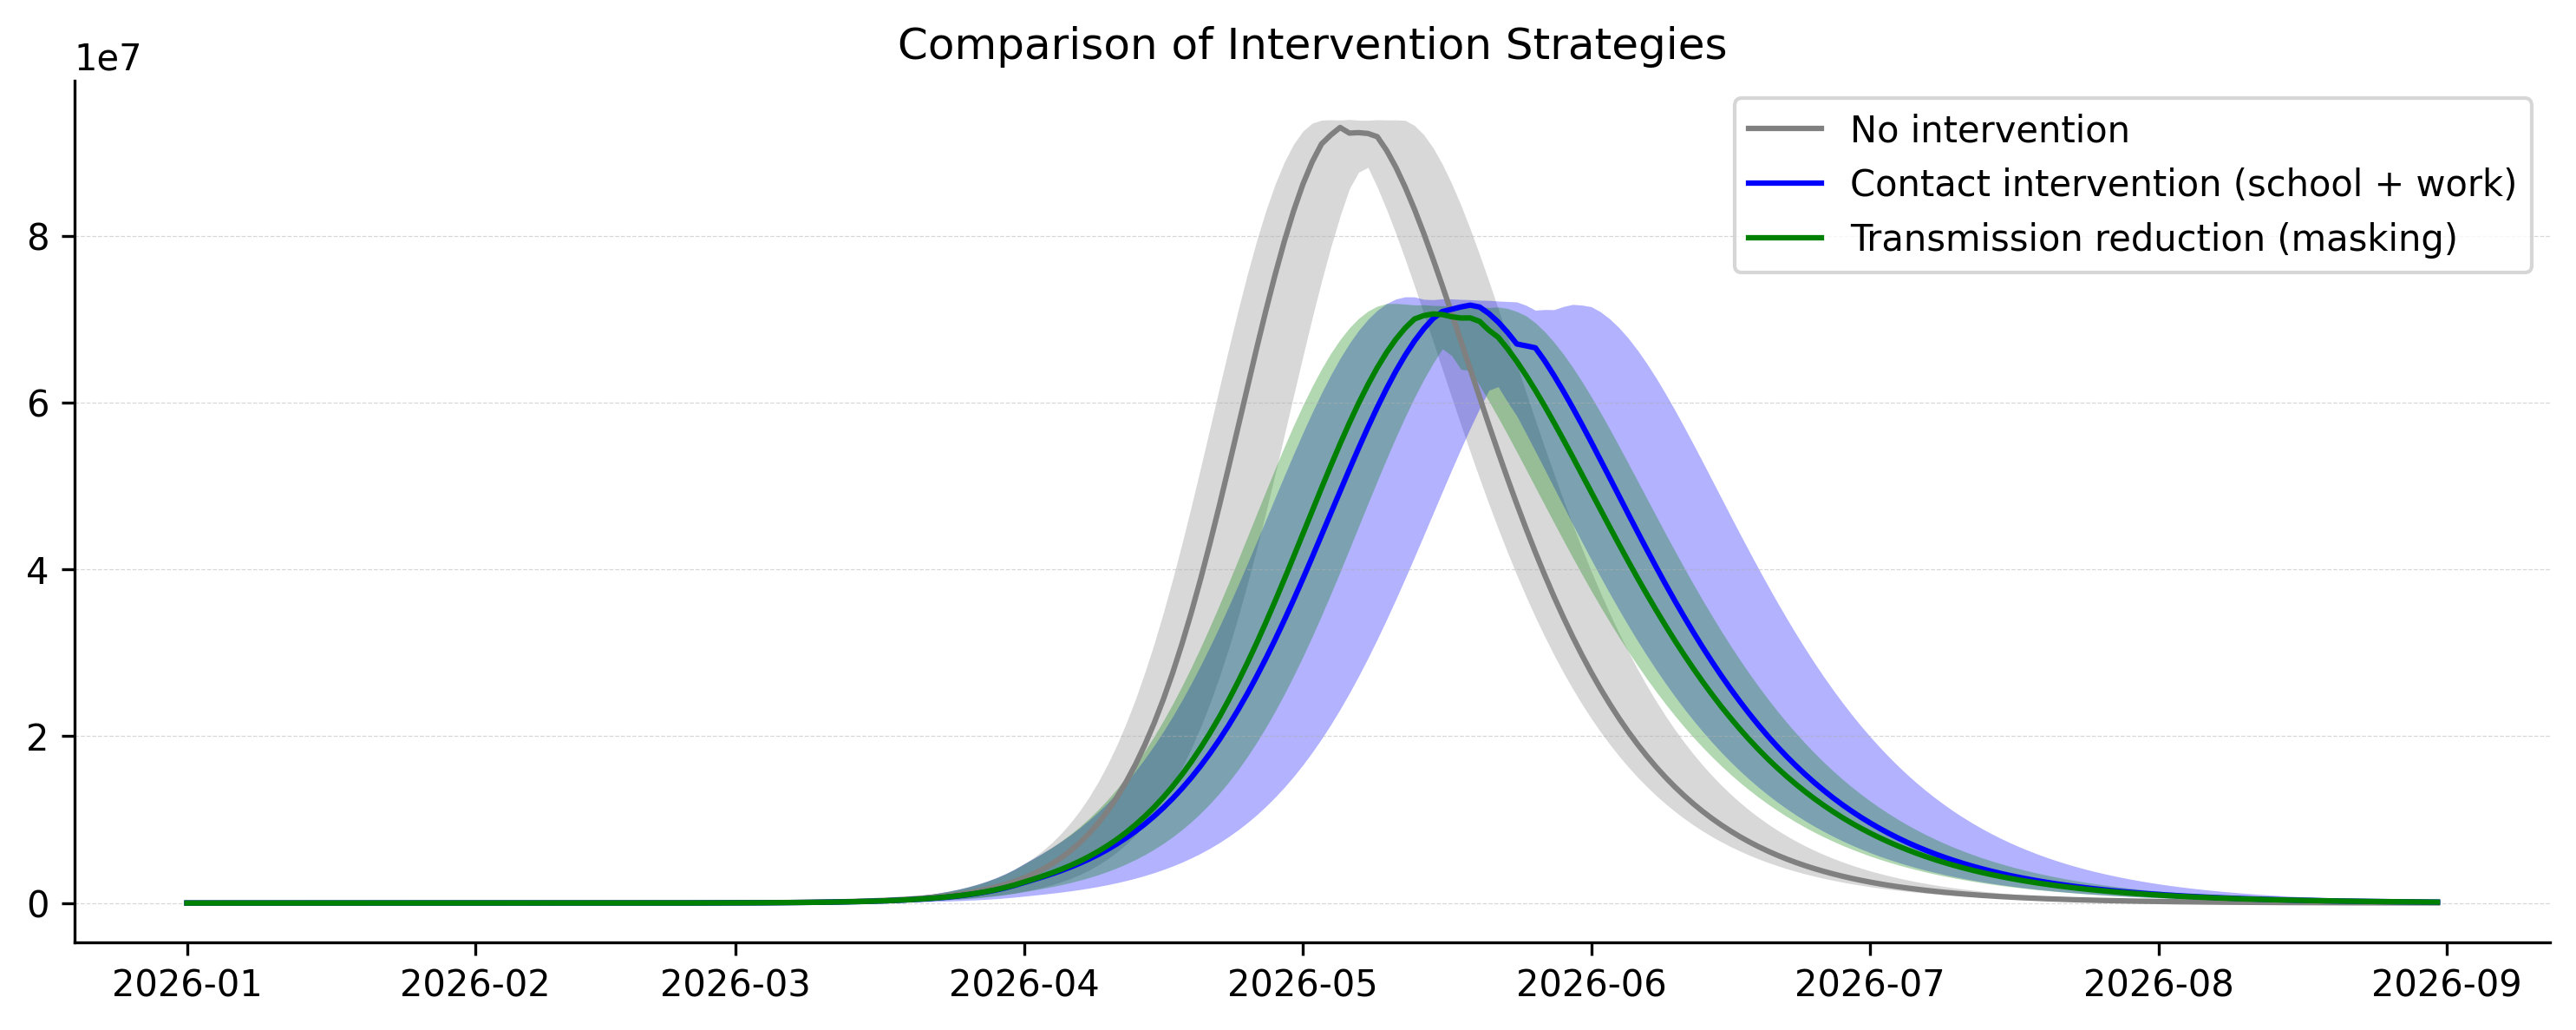

In [17]:
%%R
# Get quantiles for each scenario
df_baseline <- results_baseline$get_quantiles_compartments()
df_contact <- results_contact$get_quantiles_compartments()
df_transmission <- results_transmission$get_quantiles_compartments()

# Plot comparison
ax <- plot_quantiles(
  df_baseline,
  columns = c("I_total"),
  colors = "gray",
  labels = "No intervention"
)

ax <- plot_quantiles(
  df_contact,
  columns = c("I_total"),
  colors = "blue",
  labels = "Contact intervention (school + work)",
  ax = ax
)

ax <- plot_quantiles(
  df_transmission,
  columns = c("I_total"),
  colors = "green",
  labels = "Transmission reduction (masking)",
  ax = ax
)

ax$set_title("Comparison of Intervention Strategies")
ax$legend()
ax

### Quantifying Impact

Let's calculate the reduction in total infections and peak size.

In [43]:
%%R
# Get full trajectories
traj_baseline <- results_baseline$get_stacked_compartments()
traj_contact <- results_contact$get_stacked_compartments()
traj_transmission <- results_transmission$get_stacked_compartments()

# Total infections (final R count)
R_baseline <- py_to_r(traj_baseline["R_total"])$R_total
R_contact <- py_to_r(traj_contact["R_total"])$R_total
R_transmission <- py_to_r(traj_transmission["R_total"])$R_total
total_baseline <- R_baseline[, ncol(R_baseline)]
total_contact <- R_contact[, ncol(R_contact)]
total_transmission <- R_transmission[, ncol(R_transmission)]

averted_contact <- (total_baseline - total_contact) / total_baseline * 100
averted_transmission <- (total_baseline - total_transmission) / total_baseline * 100

# Peak infections
I_baseline <- py_to_r(traj_baseline["I_total"])$I_total
I_contact <- py_to_r(traj_contact["I_total"])$I_total
I_transmission <- py_to_r(traj_transmission["I_total"])$I_total
peak_baseline <- apply(I_baseline, 1, max)
peak_contact <- apply(I_contact, 1, max)
peak_transmission <- apply(I_transmission, 1, max)

peak_reduction_contact <- (peak_baseline - peak_contact) / peak_baseline * 100
peak_reduction_transmission <- (peak_baseline - peak_transmission) / peak_baseline * 100

# Print results
cat("Contact intervention (school + work):\n")
cat(sprintf("  Infections averted: %.1f%% (IQR: %.1f–%.1f%%)\n",
            median(averted_contact),
            quantile(averted_contact, 0.25),
            quantile(averted_contact, 0.75)))
cat(sprintf("  Peak reduction: %.1f%% (IQR: %.1f–%.1f%%)\n",
            median(peak_reduction_contact),
            quantile(peak_reduction_contact, 0.25),
            quantile(peak_reduction_contact, 0.75)))

cat("\nTransmission reduction (masking):\n")
cat(sprintf("  Infections averted: %.1f%% (IQR: %.1f–%.1f%%)\n",
            median(averted_transmission),
            quantile(averted_transmission, 0.25),
            quantile(averted_transmission, 0.75)))
cat(sprintf("  Peak reduction: %.1f%% (IQR: %.1f–%.1f%%)\n",
            median(peak_reduction_transmission),
            quantile(peak_reduction_transmission, 0.25),
            quantile(peak_reduction_transmission, 0.75)))

Contact intervention (school + work):
  Infections averted: 2.8% (IQR: 2.8–2.8%)
  Peak reduction: 23.0% (IQR: 22.8–23.1%)

Transmission reduction (masking):
  Infections averted: 4.6% (IQR: 4.6–4.7%)
  Peak reduction: 23.7% (IQR: 23.6–23.8%)


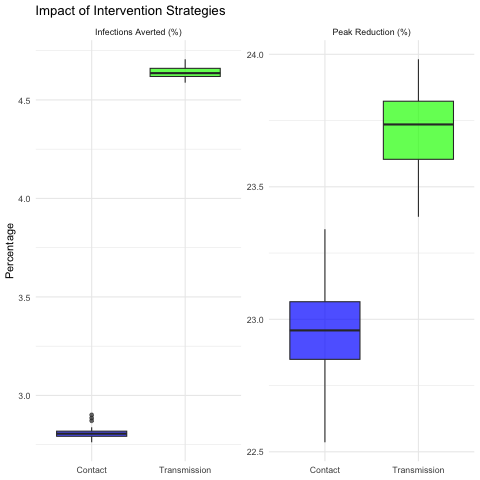

In [44]:
%%R
library(ggplot2)
library(tibble)

# Build data frame for plotting
df_impact <- tibble(
  metric = c(
    rep("Infections Averted (%)", length(averted_contact) + length(averted_transmission)),
    rep("Peak Reduction (%)", length(peak_reduction_contact) + length(peak_reduction_transmission))
  ),
  intervention = c(
    rep("Contact", length(averted_contact)),
    rep("Transmission", length(averted_transmission)),
    rep("Contact", length(peak_reduction_contact)),
    rep("Transmission", length(peak_reduction_transmission))
  ),
  value = c(
    averted_contact, averted_transmission,
    peak_reduction_contact, peak_reduction_transmission
  )
)

# Plot
ggplot(df_impact, aes(x = intervention, y = value, fill = intervention)) +
  geom_boxplot(alpha = 0.7, show.legend = FALSE) +
  facet_wrap(~metric, scales = "free_y") +
  labs(x = NULL, y = "Percentage", title = "Impact of Intervention Strategies") +
  theme_minimal() +
  scale_fill_manual(values = c("Contact" = "blue", "Transmission" = "green"))

---
## Resources

- [Epydemix Documentation](https://epydemix.readthedocs.io/)
- [Full Tutorial Series](https://github.com/epistorm/epydemix/tree/main/tutorials)
- [Supported Geographies](https://github.com/epistorm/epydemix-data/blob/main/locations.csv)
- [Reticulate Package](https://rstudio.github.io/reticulate/)